# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

<img src="https://image.freepik.com/free-vector/cartoon-delivery-man-brings-goods-customer-from-laptop-vector-illustration-concept-with-online-shopping-services_46527-344.jpg" />

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

## Problem Statement

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

## Executive Summary

The data is webscrapped from the Shopping category in Google Play Store and Apple Appstore, 8 apps reviews were chosen for this project (Amazon, Wish, ASOS, Lazada, Ebay, Shoppee, AliExpress, Carousell). The data used was exclusive dated in 2020 only as majority of the data scrapped are from in 2020. Data cleaning was done by removing stopwords, lemmatized and Vectorized to the raw data to create bag-of-words. 

There will be 3 steps to our modelling process, with the first step classifying whether the text is a good or bad review, followed by classifying the reviews into categories created through topic modelling to group them into different subgroups.

A few classification model were used, namely LogisticRegression, MultinomialNB, SGDClassifier, RandomForest, ADABoost. LogisticRegression give us the best results in classifying our data and thus used as the final model. 

As the data set is quite big, RandomizedSearch was used instead of Gridsearch to find the best hyperparameter.



### Content Summary
- Webscrapped reviews of 8 apps from Google Play Store & Apple App Store
- Data Cleaning 
  - Removing data not in year 2020
  - Removing emoji and punctuations
  - Removing non english words
  - Lemmatization
  - Compound score calculation using VaderSentiment
- EDA
  - Plotting distribution of features
  - Topic modelling of good reviews
  - Topic modelling of bad reviews
- Machine Learning Model 
  - LogisticRegression
  - MultinomialNB
  - SGDClassifier
  - RandomForest
  - ADABoost
- Deep Learning Model
  - Convolutional Neural Network
  
### Key Findings
- Most complains are on Bad User Experience, while most good reviews are on the good overall service of the App, which is rather vague
- There is more negative reviews in 9am - 3pm period, and on Tuesdays
- There is quite a number of reviews being 1 word, or otherwise rated wrongly by the user, (e.g. review: Excellent, Rating: 1)
- The multiclass model seems to be predicting better compared to what the topic modeling originally set the topic was, which is quite interesting as the model is able to differentiate the categories clearly base on the keywords.

### Metrics
Using the following metrics to evaluate the models:
- ROC AUC curve(for Binary Classification)
  -  The ROC AUC cruve is able to tell how much model is capable of distinguishing between classes.ranging from 0 to 1, with 1 being perfectly classified.
- MCC Score
  - The Matthews correlation coefficient (MCC), instead, is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both to the size of positive elements and the size of negative elements in the dataset.
- Kappa Score(For multiclassification)
  - Cohen’s Kappa is a quantitative measure of reliability for two raters that are rating the same thing, corrected for how often that the raters may agree by chance. ranging from 0 to 1, with 1 being good.
  
- f1 score weighted
  - The F1 Scores are calculated for each label and then their average is weighted by support - which is the number of true instances for each label. It can result in an F-score that is not between precision and recall

### Final Results
**Classification (Good & Bad Reviews)**
- LogisticRegression
  - Train data AUC: 0.947
  - Test data AUC: 0.945
  - MCC Score: 0.729
  
  
**Multi Classification (Bad Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.867	
    - Test Data f1 weighted score: 0.862	
    - MCC Score: 0.798336	
    - Kappa Score: 0.796888


**Multi Classification (Good Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.937	
    - Test Data f1 weighted score: 0.944	
    - MCC Score: 0.907	
    - Kappa Score: 0.906

### Limitations
- The data set is mostly collected in the month of August and September, which means the model is able to predict this period better, but not in predicting past data. 
- More data could be collected, as there is a major lack of Apple Appstore reviews compared to Google Play Store

### Further research
- Try to use Compound score gathered from VaderSentiment to do the classification instead, as we know there is some misclassified post by users. which hopefully give us a better accuracy.

### Content
1. Webscrap data
2. Data Cleaning
3. EDA
4. Model Part 1, Classification (Good & Bad Reviews)
5. Model Part 2, Multi Classification (Bad Review categories) 
6. Model Part 3, Multi Classification (Good Review categories)
7. Deep Learning Model

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import matthews_corrcoef, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

In [2]:
df = pd.read_csv('../data/reviews_Model.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,...,neu_score,pos_score,compound_score,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,...,0.707,0.293,0.4404,9,3,20,26,47,8,Satisfied Purchase
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,...,0.408,0.592,0.4404,9,3,20,13,19,3,Good User Experience
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase,first happy,purchase experience purchase,NaN,NaN,...,0.714,0.286,0.3400,9,3,20,11,57,7,Good User Experience
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,...,0.715,0.285,0.4927,9,3,20,8,35,9,Online Purchase
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,...,1.000,0.000,0.0000,9,3,19,37,16,3,Fast Delivery


## Taking out all bad reviews for training

In [4]:
df[df['rating'] <= 3 ]['category'].value_counts(normalize = True)

User Interface Issue              0.211233
Refund Issue                      0.206039
Poor Customer Service (Seller)    0.152504
Bad Experience (Seller)           0.120230
Payment Issue                     0.063024
Poor Customer Service (In-app)    0.058730
Bad Search Engine                 0.058245
Poor User Experience              0.054574
Account Issue                     0.054505
Unsatisfied In-app Event          0.020916
Name: category, dtype: float64

In [5]:
df = df[df['rating'] <= 3 ][['category', 'clean_content', 'review']]
df.head()

,category,clean_content,review
11,User Interface Issue,stupid bubble game impossible tap bubble chang...,Stupid shoppee bubble game. Impossible. When t...
40,User Interface Issue,recent update shoppe bubble game unplayable li...,Recent update make shoppe bubble game unplayab...
69,Poor Customer Service (In-app),d come contact live chat rep purposely waste t...,Was quite ok with d app until I came into cont...
122,Account Issue,aware manage beat claim certain voucher able u...,Be aware that even though you managed to beat ...
139,Poor Customer Service (Seller),delete account receive defective item seller g...,Deleted the app and my account. Received sever...


In [6]:
#Checking null values
df.isna().sum()

category         0
clean_content    0
review           0
dtype: int64

## Train Test Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['category'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['category'])

In [8]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 11551, X_test rows: 2888
y_train rows: 11551, y_test rows: 2888


## Baseline Model

In [9]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(11551, 5000)
(2888, 5000)


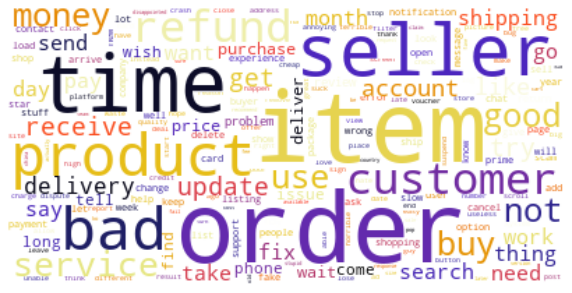

In [10]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.9538568089342914
Accuracy score for Test data set: 0.7839335180055401


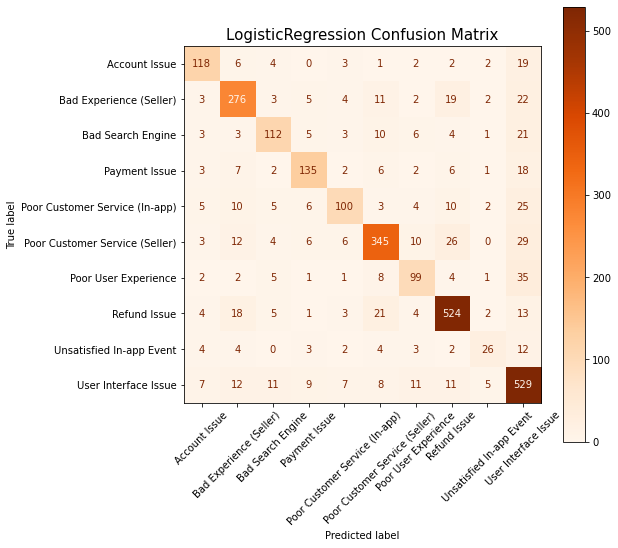

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(lr, test_data_features, y_test, ax = ax, cmap='Oranges', xticks_rotation=45);

In [13]:
print(classification_report(y_test, lr.predict(test_data_features), digits=3))

                                precision    recall  f1-score   support

                 Account Issue      0.776     0.752     0.764       157
       Bad Experience (Seller)      0.789     0.795     0.792       347
             Bad Search Engine      0.742     0.667     0.702       168
                 Payment Issue      0.789     0.742     0.765       182
Poor Customer Service (In-app)      0.763     0.588     0.664       170
Poor Customer Service (Seller)      0.827     0.782     0.804       441
          Poor User Experience      0.692     0.627     0.658       158
                  Refund Issue      0.862     0.881     0.871       595
      Unsatisfied In-app Event      0.619     0.433     0.510        60
          User Interface Issue      0.732     0.867     0.794       610

                      accuracy                          0.784      2888
                     macro avg      0.759     0.713     0.732      2888
                  weighted avg      0.784     0.784     0.781 

## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [14]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [7000, 8000],
    'cvec__min_df': [3, 4],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = RandomizedSearchCV(cvec_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=7000, min_df=3)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  205.583s


### TFIDVectorizer Logistic Regression

In [15]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.3min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  202.912s


### HashingVectorizer Logistic Regression

In [16]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [6000, 7000],
    'hash__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = RandomizedSearchCV(hash_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\Sim Yi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=6000)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  107.403s


In [17]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,CountVectorizer,0.760743,0.765924,0.717042,206
1,LogisticRegression,TFIDVectorizer,0.779263,0.781873,0.746096,203
2,LogisticRegression,HashingVectorizer,0.759738,0.760630,0.723394,107


In [18]:
print(classification_report(y_test, gs_tfid_lr.predict(X_test), digits=3))

                                precision    recall  f1-score   support

                 Account Issue      0.801     0.745     0.772       157
       Bad Experience (Seller)      0.814     0.781     0.797       347
             Bad Search Engine      0.772     0.625     0.691       168
                 Payment Issue      0.831     0.703     0.762       182
Poor Customer Service (In-app)      0.802     0.547     0.650       170
Poor Customer Service (Seller)      0.826     0.785     0.805       441
          Poor User Experience      0.771     0.576     0.659       158
                  Refund Issue      0.853     0.894     0.873       595
      Unsatisfied In-app Event      0.377     0.717     0.494        60
          User Interface Issue      0.734     0.875     0.798       610

                      accuracy                          0.783      2888
                     macro avg      0.758     0.725     0.730      2888
                  weighted avg      0.793     0.783     0.782 

## Trying with Different Models

### Logistic Regression

In [19]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(0, 10, 11))
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_lr_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_lr_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.2min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=8.0, max_iter=5000))])
Fit time:  318.991s


### MultinomialNB

In [20]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0,1,11))
}

gs_tfid_nb = RandomizedSearchCV(tfid_nb, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_nb.fit(X_train, y_train)
tfid_nb_test_time = time() - t0
print(f'Best MultinomialNB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_nb_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.4s finished


Best MultinomialNB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=4)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('nb', MultinomialNB(alpha=0.8))])
Fit time:  44.148s


### SGDClassifier

In [21]:
# Setting pipeline for two stages
tfid_clf = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('clf', SGDClassifier())
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'clf__penalty': ('l2', 'elasticnet'),
    
    
}

gs_tfid_clf = RandomizedSearchCV(tfid_clf, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_clf.fit(X_train, y_train)
tfid_clf_test_time = time() - t0
print(f'Best SGDClassifier Parameters: {gs_tfid_clf.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_clf_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


Best SGDClassifier Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('clf', SGDClassifier(penalty='elasticnet'))])
Fit time:  65.149s


### RandomForest

In [22]:
# Setting pipeline for two stages
tfid_ran = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('rf', RandomForestClassifier(random_state = 42, min_samples_leaf = 2, min_samples_split = 3))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [8, 15, 25],
    'rf__min_samples_split': [5, 15, 100],
    'rf__max_leaf_nodes': [10, None]
}

gs_tfid_ran = RandomizedSearchCV(tfid_ran, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ran.fit(X_train, y_train)
tfid_ran_test_time = time() - t0
print(f'Best RandomForest Parameters: {gs_tfid_ran.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ran_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.0min finished


Best RandomForest Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('rf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=500,
                                        random_state=42))])
Fit time:  190.398s


### Adaboost

In [23]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'ada__n_estimators': [100,150,200],
    'ada__learning_rate': list(np.linspace(0.3,1,5))
}

gs_tfid_ada = RandomizedSearchCV(tfid_ada, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
tfid_ada_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ada_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.6min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.6499999999999999,
                                    n_estimators=150))])
Fit time:  587.284s


### Accuracy & F1 Macro Score

In [24]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])


summary.append(['MultinomialNB', 'TFIDVectorizer', 
                gs_tfid_nb.best_score_,
                gs_tfid_nb.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_nb.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_nb.predict(X_test)),
                round(tfid_nb_test_time)])

summary.append(['SGDClassifier', 'TFIDVectorizer', 
                gs_tfid_clf.best_score_,
                gs_tfid_clf.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_clf.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_clf.predict(X_test)),
                round(tfid_clf_test_time)])

summary.append(['RandomForest', 'TFIDVectorizer', 
                gs_tfid_ran.best_score_,
                gs_tfid_ran.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ran.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_ran.predict(X_test)),
                round(tfid_ran_test_time)])



summary.append(['Adaboost', 'TFIDVectorizer', 
                gs_tfid_ada.best_score_,
                gs_tfid_ada.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ada.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_ada.predict(X_test)),
                round(tfid_ada_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'Kappa_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,Kappa_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.796423,0.801217,0.769080,0.768801,319
1,MultinomialNB,TFIDVectorizer,0.744102,0.756433,0.726304,0.723487,44
2,SGDClassifier,TFIDVectorizer,0.762279,0.767459,0.733563,0.732445,65
3,RandomForest,TFIDVectorizer,0.632025,0.612333,0.556460,0.555019,190
4,Adaboost,TFIDVectorizer,0.590588,0.581420,0.511805,0.510276,587


## Confusion Matrix

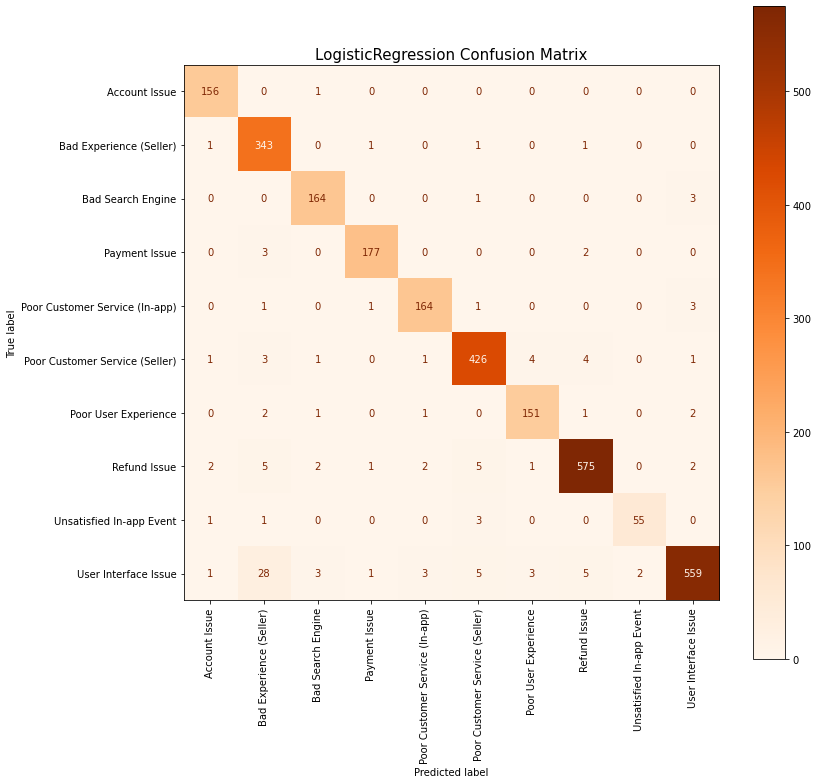

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax, cmap='Oranges', xticks_rotation=90);

In [56]:
best_model_coef = pd.DataFrame(data = gs_tfid_lr.best_estimator_.named_steps['lr'].coef_, 
                               index = gs_tfid_lr.best_estimator_.named_steps['lr'].classes_,
                               columns = gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names()).T

best_model_coef

,Account Issue,Bad Experience (Seller),Bad Search Engine,Payment Issue,Poor Customer Service (In-app),Poor Customer Service (Seller),Poor User Experience,Refund Issue,Unsatisfied In-app Event,User Interface Issue
10,-0.015695,-0.055146,-0.341729,-0.058346,-0.060310,-0.022663,-0.119978,1.150830,-0.002582,-0.474380
10th,-0.001471,-0.002794,-0.024204,-0.004184,-0.295954,0.028096,-0.009828,0.315009,-0.002238,-0.002432
10x,-0.038054,0.101463,-0.418992,-0.226483,-0.082198,-0.680811,1.447264,0.640991,-0.034738,-0.708443
11th,-0.023674,-0.383935,-0.026757,-0.026591,-0.035363,-0.104532,-0.009866,0.685544,-0.049439,-0.025386
12th,-0.006244,-0.102005,0.539102,-0.019394,-0.022412,-0.020783,-0.047865,0.003750,-0.004424,-0.319724
...,...,...,...,...,...,...,...,...,...,...
zip,0.560151,-0.296609,-0.352784,-0.624773,-0.108783,-0.609411,-0.894316,-0.509345,-0.046158,2.882030
zoom,-0.989236,-1.293173,5.382214,-1.327204,-1.334876,-1.503629,-0.304073,-0.920913,-0.391546,2.682437
งเต,1.830716,-1.076525,-0.589020,-0.837138,-0.648111,-0.632292,1.469374,-0.161839,-0.179530,0.824365
นค,-0.385005,-0.647801,-0.797992,-0.894330,-0.697118,-0.746763,2.780241,-0.228157,-0.231609,1.848534


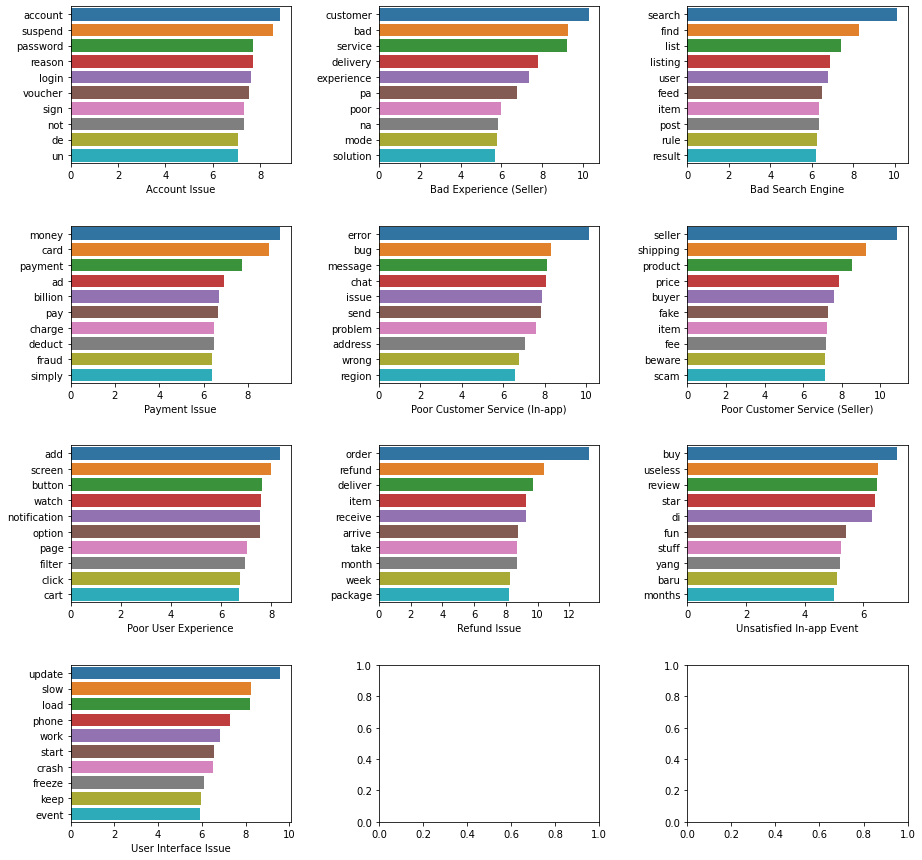

In [134]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (15,15))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = ax.ravel()
for i in range(len(best_model_coef.columns)):
    sns.barplot(x = best_model_coef[best_model_coef.columns[i]].sort_values(ascending = False)[:10], 
                y = best_model_coef[best_model_coef.columns[i]].sort_values(ascending = False)[:10].index,
                ax = ax[i]);

## Checking Misclassified Post

In [26]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(X_test), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
62004,Refund Issue,Bad Experience (Seller),"Good easy yo use app. However, the shipping st...",good easy yo use shipping status message diffi...
62160,Bad Experience (Seller),User Interface Issue,Juju. I,juju
50804,Refund Issue,Bad Experience (Seller),Pathetic Service. I got very bad experience wi...,pathetic service get bad experience multiple t...
61128,Poor Customer Service (In-app),Bad Search Engine,This app should be made to be compatible with ...,compatible operating system operate system seg...
72138,Account Issue,Bad Experience (Seller),Unclear info about voucher when sell,unclear voucher sell
19187,User Interface Issue,Unsatisfied In-app Event,Tolong dong pihak lazada untuk jasa pengiriman...,dong express lain para saya express blan saya ...
24528,Bad Experience (Seller),Payment Issue,I don't know why you should support thieves,know support thief
50876,Bad Experience (Seller),User Interface Issue,Crummy,crummy
2906,Bad Search Engine,Refund Issue,It can be hard to return to the homepage after...,hard return move shop
10262,Poor Customer Service (In-app),Poor Customer Service (Seller),Carousell and its management deserves a specia...,management deserve special place hell greed


### Comments
- Some of the reviews are predicted wrongly. After looking at some of the reviews, it is clear that there are some misclassification by the topic modelling.
- It can be seen that the model is actually predicting better then what was classified in the first place.


## Train data on whole dataset

In [27]:
best_model = gs_tfid_lr.best_estimator_
best_model

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=8.0, max_iter=5000))])

In [28]:
best_model.fit(df['clean_content'], df['category'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=8.0, max_iter=5000))])

In [29]:
filename = 'Best_Model_BadReview_P2.sav'
pickle.dump(best_model, open('./model_pickles/' + filename, 'wb'))